# import libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy 
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score
from custom_resnet18 import CustomCNN
import psutil
import time

# training and testing functions

In [2]:
import time

def train_model(train_loader, learning_rate, num_epochs):
    # Print training details
    batch_size = train_loader.batch_size
    print(f"Batch Size: {batch_size}")
    print(f"Number of Epochs: {num_epochs}")
    print(f"Learning Rate (starting): {learning_rate}")

    # Modify the model's final layer
    model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward propagation
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print loss per epoch
        print(f"Epoch: [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    # Calculate latency for a single sample
    model.eval() 
    with torch.no_grad():
        start_time = time.time()
        for images, _ in train_loader:
            images = images.to(device)
            # Simulate processing a single sample
            for i in range(images.size(0)):
                _ = model(images[i].unsqueeze(0))
            break  # Measure for one batch
        end_time = time.time()

    # Latency per sample
    latency_per_sample = (end_time - start_time) / images.size(0)
    print(f"Latency per sample: {latency_per_sample * 1000:.2f} ms")


def measure_latency_cpu_usage(model, test_inputs):
    process = psutil.Process()
    cpu_start = process.cpu_percent()
    start = time.time()
    predictions = model(test_inputs)
    end = time.time()
    cpu_end = process.cpu_percent()
    latency = end - start
    cpu_usage = cpu_end - cpu_start
    return latency, cpu_usage

def test_model(test_loader, model, device):
    model.eval()
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    
    total_latency = 0
    total_cpu_usage = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Measure latency and CPU usage
            latency, cpu_usage = measure_latency_cpu_usage(model, images)
            total_latency += latency
            total_cpu_usage += cpu_usage
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predicted_labels.extend(predicted.to('cpu').tolist())
            true_labels.extend(labels.to('cpu').tolist())
    
    # Calculate averages
    avg_latency_per_batch = total_latency / len(test_loader)
    avg_cpu_usage = total_cpu_usage / len(test_loader)
    accuracy = 100 * correct / total
    
    print(f"Average Latency per Batch: {avg_latency_per_batch * 1000:.2f} ms")
    print(f"Average CPU Usage per Batch: {avg_cpu_usage:.2f}%")
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    return predicted_labels, true_labels


# setting the device for execution - gpu or cpu

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters

In [4]:
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate =0.0001

# pre processing functions

In [5]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## downloading public dataset - CIFAR10

In [6]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transforms, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transforms, download=True)

Files already downloaded and verified
Files already downloaded and verified


# loading dataset by batch size to be used by pytorch for training and testing

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


# loading ResNet18 model

In [8]:
model = CustomCNN(10)

# training the model

In [9]:
train_model(train_loader,learning_rate,num_epochs)

Batch Size: 32
Number of Epochs: 10
Learning Rate (starting): 0.0001
Epoch: [1/10], Loss: 1.5710
Epoch: [2/10], Loss: 1.1783
Epoch: [3/10], Loss: 0.9981
Epoch: [4/10], Loss: 0.8721
Epoch: [5/10], Loss: 0.7758
Epoch: [6/10], Loss: 0.6948
Epoch: [7/10], Loss: 0.6258
Epoch: [8/10], Loss: 0.5599
Epoch: [9/10], Loss: 0.5022
Epoch: [10/10], Loss: 0.4443
Latency per sample: 1.47 ms


# testing the model


In [10]:
predictedLabels,trueLabels = test_model(test_loader,model)

Test Accuracy: 75.50%


# plotting confusion matrix

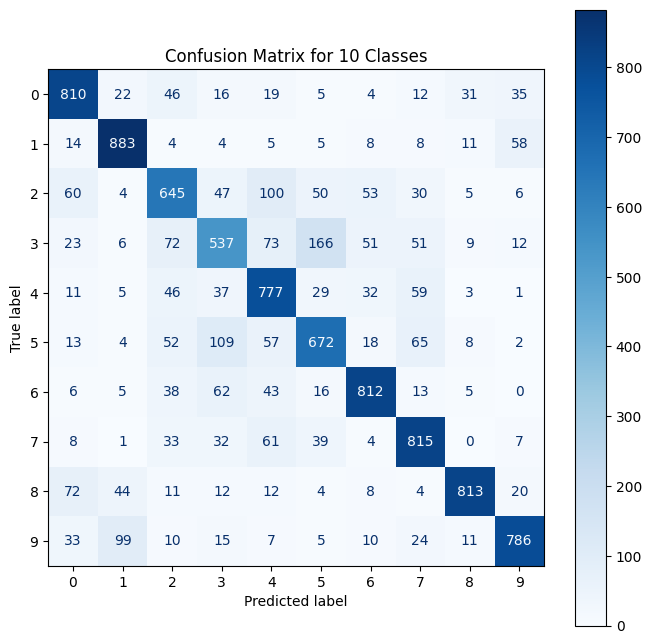

In [11]:
cm = confusion_matrix(trueLabels, predictedLabels)
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(10))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix for 10 Classes")
plt.show()


# calculating f1 score

In [12]:
f1_score_data = f1_score(trueLabels, predictedLabels,average=None)
for i in f1_score_data:
    print(f'Class {numpy.where(f1_score_data==i)[0][0]} : {i}')

Class 0 : 0.7902439024390244
Class 1 : 0.8519054510371442
Class 2 : 0.6591722023505365
Class 3 : 0.5740245857830037
Class 4 : 0.7214484679665738
Class 5 : 0.6750376695128076
Class 6 : 0.812
Class 7 : 0.7832772705430082
Class 8 : 0.8575949367088608
Class 9 : 0.8157758173326414


# update batch size

In [13]:
batch_size = 64 # previously 32

# update dataloader to set the updated batch size

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# training the model

In [15]:
train_model(train_loader,learning_rate,num_epochs)

Batch Size: 64
Number of Epochs: 10
Learning Rate (starting): 0.0001
Epoch: [1/10], Loss: 0.3591
Epoch: [2/10], Loss: 0.3103
Epoch: [3/10], Loss: 0.2747
Epoch: [4/10], Loss: 0.2427
Epoch: [5/10], Loss: 0.2126
Epoch: [6/10], Loss: 0.1886
Epoch: [7/10], Loss: 0.1651
Epoch: [8/10], Loss: 0.1449
Epoch: [9/10], Loss: 0.1279
Epoch: [10/10], Loss: 0.1153
Latency per sample: 0.65 ms


# testing the model

In [16]:
predictedLabels,trueLabels = test_model(test_loader,model)

Test Accuracy: 75.14%


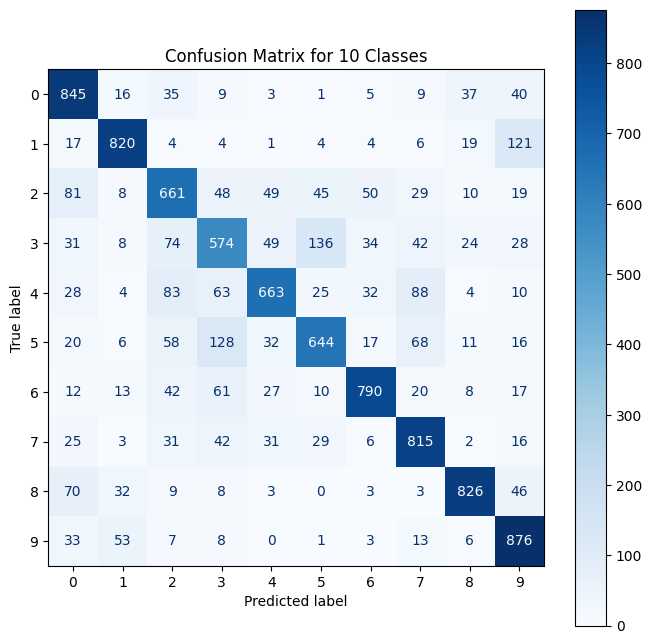

In [17]:
cm = confusion_matrix(trueLabels, predictedLabels)
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(10))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix for 10 Classes")
plt.show()


In [18]:
f1_score_data = f1_score(trueLabels, predictedLabels,average=None)
for i in f1_score_data:
    print(f'Class {numpy.where(f1_score_data==i)[0][0]} : {i}')

Class 0 : 0.7816836262719704
Class 1 : 0.8354559347936832
Class 2 : 0.6596806387225549
Class 3 : 0.5902313624678663
Class 4 : 0.7136706135629709
Class 5 : 0.6796833773087071
Class 6 : 0.8127572016460906
Class 7 : 0.7787864309603441
Class 8 : 0.8484848484848485
Class 9 : 0.8003654636820466


# updating num of epochs

In [19]:
num_epochs = 50 # previously 10

In [ ]:
train_model(train_loader,learning_rate,num_epochs)

Batch Size: 64
Number of Epochs: 50
Learning Rate (starting): 0.0001
Epoch: [1/50], Loss: 0.1042
Epoch: [2/50], Loss: 0.0949
Epoch: [3/50], Loss: 0.0868
Epoch: [4/50], Loss: 0.0806
Epoch: [5/50], Loss: 0.0724
Epoch: [6/50], Loss: 0.0662
Epoch: [7/50], Loss: 0.0634
Epoch: [8/50], Loss: 0.0605
Epoch: [9/50], Loss: 0.0536
Epoch: [10/50], Loss: 0.0496
Epoch: [11/50], Loss: 0.0509
Epoch: [12/50], Loss: 0.0506
Epoch: [13/50], Loss: 0.0512
Epoch: [14/50], Loss: 0.0422
Epoch: [15/50], Loss: 0.0411
Epoch: [16/50], Loss: 0.0435
Epoch: [17/50], Loss: 0.0404
Epoch: [18/50], Loss: 0.0397
Epoch: [19/50], Loss: 0.0395
Epoch: [20/50], Loss: 0.0333
Epoch: [21/50], Loss: 0.0351
Epoch: [22/50], Loss: 0.0345
Epoch: [23/50], Loss: 0.0365
Epoch: [24/50], Loss: 0.0344
Epoch: [25/50], Loss: 0.0305
Epoch: [26/50], Loss: 0.0332


In [ ]:
predictedLabels,trueLabels = test_model(test_loader,model)

In [ ]:
cm = confusion_matrix(trueLabels, predictedLabels)
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(10))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix for 10 Classes")
plt.show()


In [ ]:
f1_score_data = f1_score(trueLabels, predictedLabels,average=None)
for i in f1_score_data:
    print(f'Class {numpy.where(f1_score_data==i)[0][0]} : {i}')

In [24]:
learning_rate = 0.001 # previously 0.0001

In [ ]:
train_model(train_loader,learning_rate,num_epochs)

In [ ]:
predictedLabels,trueLabels = test_model(test_loader,model)

In [ ]:
cm = confusion_matrix(trueLabels, predictedLabels)
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(10))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix for 10 Classes")
plt.show()


In [ ]:
f1_score_data = f1_score(trueLabels, predictedLabels,average=None)
for i in f1_score_data:
    print(f'Class {numpy.where(f1_score_data==i)[0][0]} : {i}')

# performing image augmentations

In [29]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),   # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color adjustments
    transforms.RandomRotation(15),         # Random rotation within 15 degrees
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

# Test data transformations (no augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])


In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
train_model(train_loader,learning_rate,num_epochs)

In [ ]:
predictedLabels,trueLabels = test_model(test_loader,model)

In [ ]:
cm = confusion_matrix(trueLabels, predictedLabels)
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=range(10))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix for 10 Classes")
plt.show()


In [ ]:
f1_score_data = f1_score(trueLabels, predictedLabels,average=None)
for i in f1_score_data:
    print(f'Class {numpy.where(f1_score_data==i)[0][0]} : {i}')

# adding tensor rt


In [ ]:
import torch_tensorrt

In [ ]:
dummy_input = torch.randn(1, 3, 128, 128).cuda()
trt_model = torch_tensorrt.compile(
    model,
    inputs =[torch_tensorrt.Input(dummy_input.shape)],
    enabled_precisions={torch.half},
        workspace_size=2 * (1024**3),  
)
test_model(test_loader,trt_model,device=device)